In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
import pandas as pd

In [2]:
def log_results(results, filename, type_):
    # Define the headers for your CSV file

    if type_ == '1k_logs':
        headers = ['Mean Episodic Reward', 'Critic loss', 'Actor loss']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)

    elif type_ == '20k_ep_rewards':
        headers = ['Mean episodic reward']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)


In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions),
            nn.Softmax()
        )

    def forward(self, x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Actor_continuous(nn.Module):

    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.Tensor(x)
        mean = self.model(x)
        log_std = self.log_std

        return mean, log_std

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [6]:
class A2C_Agent(): #this should work with more parallel environment already, not the evaluate functions

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic, continuous = False):
        self.n_envs = n_envs
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
        self.continuous = continuous
    

    def choose_action(self, states, pr = False, action_type = "training"):          

        if not self.continuous : 
            if action_type == "training":
                state_values = self.critic(states)
                action_probs = self.actor(states)
                actions_pd = torch.distributions.Categorical(probs=action_probs)
                actions = actions_pd.sample()
                actions_log_prog = actions_pd.log_prob(actions)
                if pr:
                    print(action_probs)
                    print(actions)
                    print(actions_log_prog)
                return actions, actions_log_prog, state_values
            
            elif action_type == 'greedy':
                with torch.no_grad()  :    
                    state_values = self.critic(states)
                    action_probs = self.actor(states)
                    actions = torch.argmax(action_probs) #greedy policy
                return actions, state_values
        
        else :
            state_values = self.critic(states)
            mean, log_std = self.actor(states)
            normal = torch.distributions.Normal(mean, torch.exp(log_std))
            actions = normal.sample()
            actions_log_prob = normal.log_prob(actions)
            actions_r = torch.clamp(actions, -3., 3.)

            return actions_r, actions_log_prob, state_values
        

        
    
    def get_losses(self, rewards, states, next_states, log_prob, gamma, terminated):
        
        delta = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * self.critic(next_states).detach()

        advantage = delta - self.critic(states)  

        critic_loss = advantage.pow(2).mean()
        
        actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach())).mean()

        return actor_loss, critic_loss
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self):
        
        episodic_rewards_10 = []
        v_values = []
        env = gym.make("CartPole-v1")
        for j in range(10):
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "greedy") #add third output for continuous, provisoire
                #get the current value function fro one trajectory (j==0)
                if j == 0 : v_values.append(state_values.detach().data.numpy()) #shitty with float
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10))
        return np.mean(episodic_rewards_10), v_values
    
    def evaluate_training(self, total_rewards, actor_loss, critic_loss, filename, type_):

        avg_reward = 0

        for v in total_rewards:
            avg_reward += np.mean(v)
        
        avg_reward /= len(total_rewards)

        log_results([avg_reward, critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filename, type_)
    


In [7]:
def train(seed, filenames, n_envs=1, n_steps=1, sparse=False):
    v_values = []
    max_steps = 500000

    env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for _ in range(n_envs)])
    state_dim  = env.single_observation_space.shape[0]
    n_actions = env.single_action_space.n

    torch.manual_seed(seed)
    actor = Actor(state_dim, n_actions)
    critic = Critic(state_dim)
    agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=1e-5, lr_critic=1e-3, continuous=False)
    
    state = env.reset(seed=seed)[0]

    total_rewards = []
    for i in range(n_envs): total_rewards.append([])
    ep_reward = [0]*n_envs

    for s in tqdm(range(max_steps)):

        ## We don't need to reset the environment since we use gym's AsyncEnv ##
        
        actions, actions_log_prog, vp = agent.choose_action(state, pr = s%2000 == 0)
        
        next_state, reward, terminated, truncated, info = env.step(actions.numpy())
        st1 = next_state.copy()

        for i in range(n_envs):
            ep_reward[i] += reward[i]
            if terminated[i] or truncated[i]:
                # print(s)
                total_rewards[i].append(ep_reward[i])
                st1[i] = info['final_observation'][i]
                ep_reward[i] = 0
                # print(state)
                # print(st1)
                # print(next_state)
        
        if sparse:
            reward = np.where(reward == 1.0, np.random.binomial(1, 0.1, size=reward.shape), reward)
            
        actor_loss, critic_loss = agent.get_losses(reward, state, st1, actions_log_prog, 0.99, terminated)
        state = next_state


        agent.update_params(critic_loss, actor_loss)
        
        if (s % 1000) == 0:
            agent.evaluate_training(total_rewards, actor_loss, critic_loss, filenames[0], "1k_logs")
            total_rewards = [[] for _ in range(n_envs)]
        if (s % 20000 == 0): 
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)]
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)



In [8]:
seeds = [42, 123, 21]
for seed in seeds:
    folder_name = 'test_sparse_'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv')]

    train(seed, filenames, n_envs=6, sparse=False)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/500000 [00:00<24:20:48,  5.70it/s]

tensor([[0.4770, 0.5230],
        [0.4735, 0.5265],
        [0.4770, 0.5230],
        [0.4776, 0.5224],
        [0.4735, 0.5265],
        [0.4762, 0.5238]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 0, 0, 0])
tensor([-0.6482, -0.6415, -0.6481, -0.7390, -0.7475, -0.7420],
       grad_fn=<SqueezeBackward1>)
episodic return of the 20000: 9.8


  0%|          | 2034/500000 [00:12<47:58, 172.98it/s]  

tensor([[0.6463, 0.3537],
        [0.6460, 0.3540],
        [0.6525, 0.3475],
        [0.6221, 0.3779],
        [0.5374, 0.4626],
        [0.5030, 0.4970]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 1, 1, 0])
tensor([-1.0392, -1.0384, -1.0569, -0.9731, -0.7709, -0.6872],
       grad_fn=<SqueezeBackward1>)


  1%|          | 4035/500000 [00:24<41:08, 200.93it/s]  

tensor([[0.4762, 0.5238],
        [0.5389, 0.4611],
        [0.6467, 0.3533],
        [0.4614, 0.5386],
        [0.5097, 0.4903],
        [0.6186, 0.3814]], grad_fn=<SoftmaxBackward0>)
tensor([1, 0, 1, 0, 1, 0])
tensor([-0.6466, -0.6181, -1.0406, -0.7734, -0.7127, -0.4802],
       grad_fn=<SqueezeBackward1>)


  1%|          | 6020/500000 [00:35<44:18, 185.81it/s]  

tensor([[0.3506, 0.6494],
        [0.7458, 0.2542],
        [0.4015, 0.5985],
        [0.7652, 0.2348],
        [0.2037, 0.7963],
        [0.5266, 0.4734]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 0, 0, 1, 1])
tensor([-1.0482, -1.3695, -0.9126, -0.2676, -0.2278, -0.7477],
       grad_fn=<SqueezeBackward1>)


  2%|▏         | 8021/500000 [00:47<43:15, 189.52it/s]  

tensor([[0.6103, 0.3897],
        [0.2578, 0.7422],
        [0.5455, 0.4545],
        [0.1706, 0.8294],
        [0.4762, 0.5238],
        [0.8675, 0.1325]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 1, 1, 0])
tensor([-0.4937, -0.2981, -0.7886, -0.1871, -0.6466, -0.1421],
       grad_fn=<SqueezeBackward1>)


  2%|▏         | 10026/500000 [00:58<41:40, 195.97it/s] 

tensor([[0.1284, 0.8716],
        [0.5286, 0.4714],
        [0.3773, 0.6227],
        [0.8535, 0.1465],
        [0.8269, 0.1731],
        [0.2862, 0.7138]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 0, 0, 1])
tensor([-0.1374, -0.7521, -0.4737, -0.1584, -0.1901, -0.3371],
       grad_fn=<SqueezeBackward1>)


  2%|▏         | 12027/500000 [01:08<41:18, 196.84it/s]  

tensor([[0.7926, 0.2074],
        [0.8822, 0.1178],
        [0.6618, 0.3382],
        [0.8797, 0.1203],
        [0.3297, 0.6703],
        [0.8025, 0.1975]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 0, 0, 0])
tensor([-1.5729, -2.1391, -1.0840, -0.1281, -1.1094, -0.2201],
       grad_fn=<SqueezeBackward1>)


  3%|▎         | 14035/500000 [01:20<38:54, 208.14it/s]  

tensor([[0.4336, 0.5664],
        [0.5296, 0.4704],
        [0.9445, 0.0555],
        [0.2461, 0.7539],
        [0.9178, 0.0822],
        [0.4766, 0.5234]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 0, 1, 0, 1])
tensor([-0.8355, -0.7543, -0.0571, -0.2825, -0.0857, -0.6474],
       grad_fn=<SqueezeBackward1>)


  3%|▎         | 16026/500000 [01:32<45:48, 176.06it/s]  

tensor([[0.3829, 0.6171],
        [0.8832, 0.1168],
        [0.6906, 0.3094],
        [0.1374, 0.8626],
        [0.5158, 0.4842],
        [0.8883, 0.1117]], grad_fn=<SoftmaxBackward0>)
tensor([1, 0, 0, 1, 0, 0])
tensor([-0.4827, -0.1242, -0.3701, -0.1478, -0.6620, -0.1184],
       grad_fn=<SqueezeBackward1>)


  4%|▎         | 18025/500000 [01:44<42:34, 188.69it/s]  

tensor([[0.0615, 0.9385],
        [0.1919, 0.8081],
        [0.1533, 0.8467],
        [0.1550, 0.8450],
        [0.8410, 0.1590],
        [0.8036, 0.1964]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 0, 0, 0])
tensor([-0.0635, -0.2130, -0.1664, -1.8643, -0.1731, -0.2187],
       grad_fn=<SqueezeBackward1>)


  4%|▍         | 19979/500000 [01:54<37:10, 215.23it/s]  

tensor([[0.5428, 0.4572],
        [0.7182, 0.2818],
        [0.7103, 0.2897],
        [0.2096, 0.7904],
        [0.6425, 0.3575],
        [0.3963, 0.6037]], grad_fn=<SoftmaxBackward0>)
tensor([1, 0, 1, 1, 0, 0])
tensor([-0.7826, -0.3310, -1.2390, -0.2353, -0.4423, -0.9256],
       grad_fn=<SqueezeBackward1>)


  4%|▍         | 20017/500000 [01:56<2:26:12, 54.71it/s]

episodic return of the 20000: 471.0


  4%|▍         | 21022/500000 [02:02<46:22, 172.16it/s]  


KeyboardInterrupt: 

In [16]:
env = gym.make('CartPole-v1')

In [17]:
env.reset(seed=42)
env.step(1)
env.step(1)
env.step(0)
env.step(1)
env.step(0)
env.step(1)
env.step(1)
env.step(0)
env.step(0)
env.step(0)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(0)
env.step(0)
env.step(1)

(array([ 0.20077482,  0.97871816, -0.22332747, -1.6830654 ], dtype=float32),
 1.0,
 True,
 False,
 {})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
                        
def plotting(folder_name, seeds):
    actors  = []
    critics = []
    rewards = []
    rewards_20 = []
    v_values = []
    v0 = []
    v1 = []
    v2 = []
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv')]
        data1 = pd.read_csv(filenames[0])
        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])
        rewards.append(data1['Mean Episodic Reward'])

        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        data3 = pd.read_csv(filenames[2])

        if i==0:
            v0.append(data3['V_Values_20000'])  #not great but ok for now
            v1.append(data3['V_Values_60000'])
            v2.append(data3['V_Values_400000'])

        for col in data3.columns:
            v_values.append(data3[col])

    print(v2)
    mean_actors = np.mean(actors, axis=0)
    mean_critics = np.mean(critics, axis=0)
    mean_rewards = np.mean(rewards, axis=0)
    mean_rewards20 = np.mean(rewards_20, axis=0)
    mean_vs = np.mean(v_values, axis=0)

    max_actors = np.max(actors, axis=0)
    max_critics = np.max(critics, axis=0)
    max_rewards = np.max(rewards, axis=0)
    max_rewards20 = np.max(rewards_20, axis=0)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards = np.min(rewards, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)


    plt.plot(range(len(mean_actors)), mean_actors, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Actor.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(rewards[0])), rewards[0], color='blue', label='seed 1')
    plt.plot(range(len(rewards[1])), rewards[1], color='red', label='seed 2')
    plt.plot(range(len(rewards[2])), rewards[2], color='green', label = 'seed 3')
    plt.xlabel('Step (*1000)')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, '3rewards.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Critic.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards)), mean_rewards, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_1k.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='Mean')

    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v0[0])), (v0[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v1[0])), (v1[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value60k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v2[0])), (v2[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value500k.jpg'), dpi=300)

[0      9.665243
1      9.665052
2      9.664274
3      9.665222
4      9.665239
         ...   
995    9.665235
996    9.665243
997    9.665241
998    9.665243
999    9.665241
Name: V_Values_400000, Length: 1000, dtype: float64]


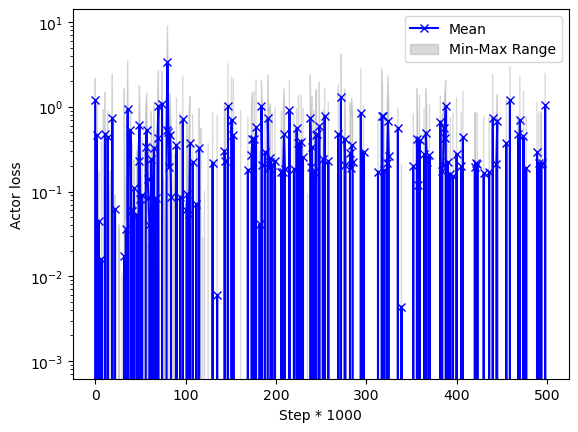

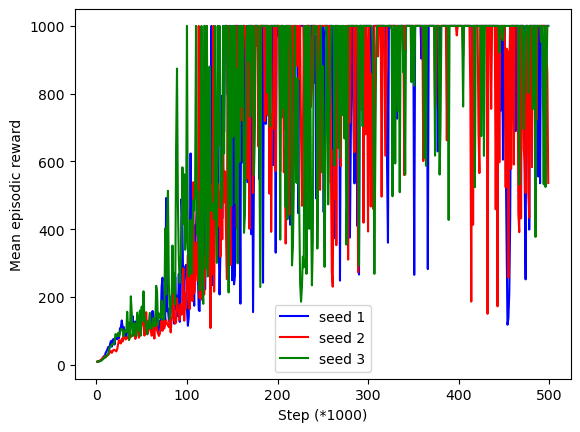

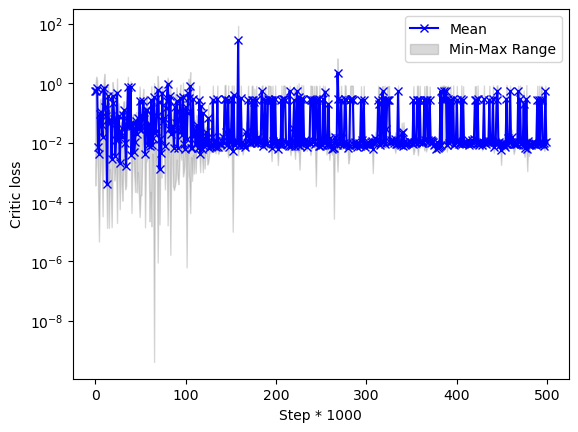

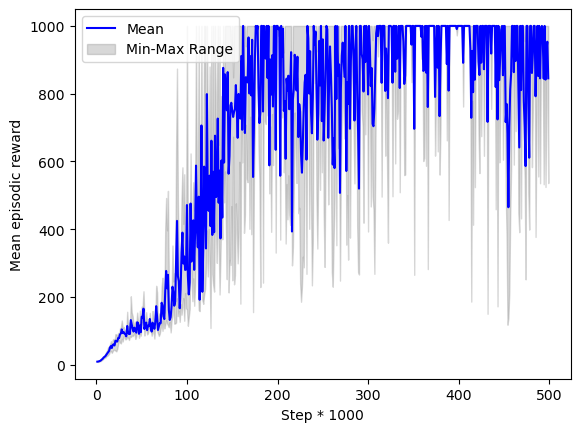

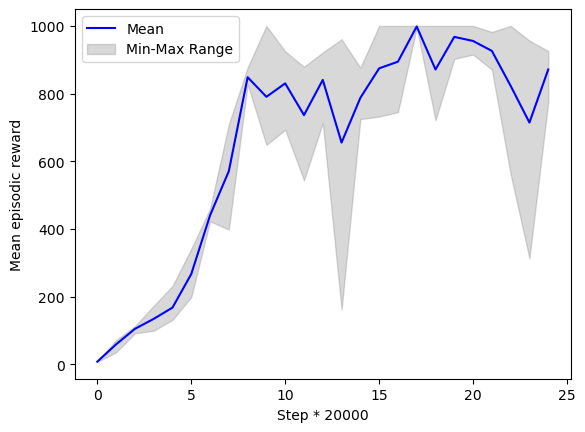

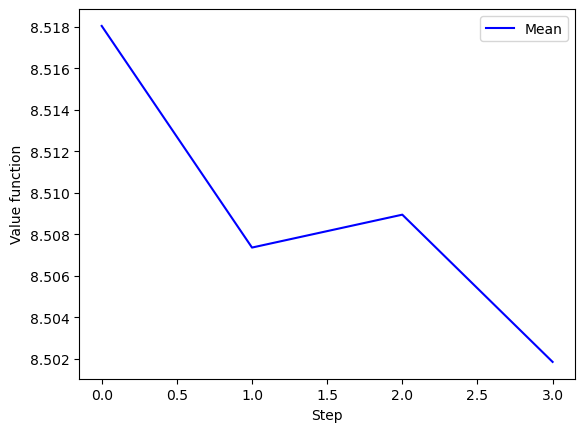

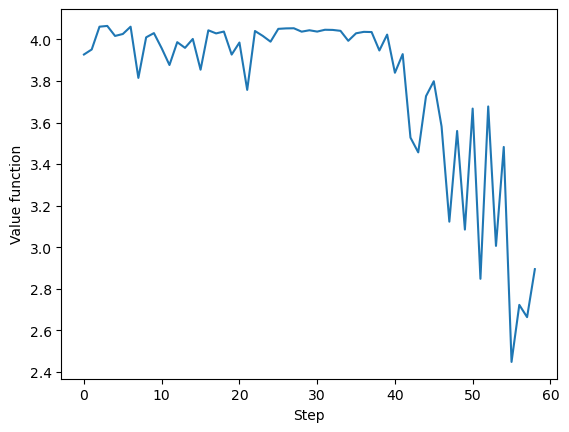

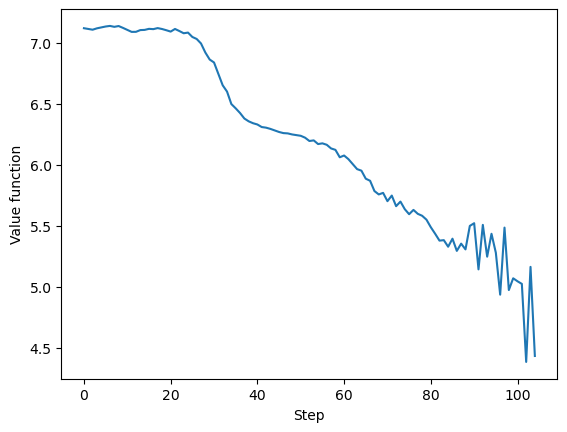

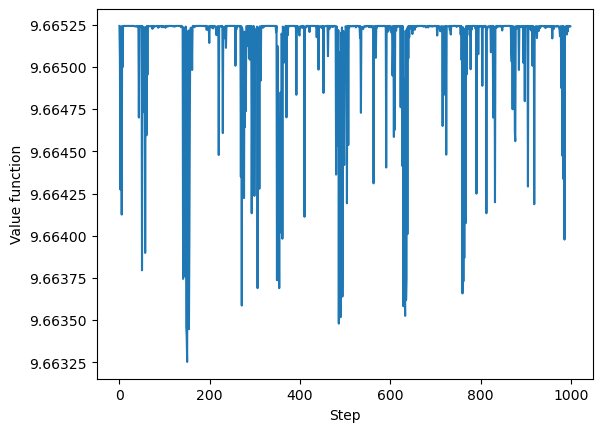

In [ ]:
folder_name = 'test_sparse'
plotting(folder_name, seeds)